In [ ]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.loading_data.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.cnn_emos.nn_forecast import CNNEMOS
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.visualization.plot_forecasts import plot_forecast_pdf_tf, plot_weight_mixture_cnns
from src.climatology.climatology import Climatology
from src.linreg_emos.emos import BootstrapEmos, LinearEMOS
from src.loading_data.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier, make_bootstrap_brier_efficient


import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [3]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [4]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_0'

climatology = Climatology.load(folder)

In [5]:
train_data0, test_data0_original, ignore = load_cv_data(0, features_names_dict)

data_load = train_data0.batch(32)

train_data0 = train_data0.batch(train_data0.cardinality())
test_data0 = test_data0_original.batch(test_data0_original.cardinality())

In [6]:
train_data1, test_data1_original, ignore = load_cv_data(1, features_names_dict)

train_data1 = train_data1.batch(train_data1.cardinality())
test_data1 = test_data1_original.batch(test_data1_original.cardinality())

In [7]:
train_data2, test_data2_original, ignore = load_cv_data(2, features_names_dict)

train_data2 = train_data2.batch(train_data2.cardinality())
test_data2 = test_data2_original.batch(test_data2_original.cardinality())

In [8]:
train_data3, test_data3_original, ignore = load_cv_data(3, features_names_dict)

train_data3 = train_data3.batch(train_data3.cardinality())
test_data3 = test_data3_original.batch(test_data3_original.cardinality())

In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base'

with open(filepath, 'rb') as f:
    emos_base = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme'

with open(filepath, 'rb') as f:
    extreme = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate'

with open(filepath, 'rb') as f:
    intermdiate = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [10]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base1'

with open(filepath, 'rb') as f:
    emos_base1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme1'

with open(filepath, 'rb') as f:
    extreme1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate1'

with open(filepath, 'rb') as f:
    intermdiate1 = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [11]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base2'

with open(filepath, 'rb') as f:
    emos_base2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme2'

with open(filepath, 'rb') as f:
    extreme2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate2'

with open(filepath, 'rb') as f:
    intermdiate2 = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base3'

with open(filepath, 'rb') as f:
    emos_base3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme3'

with open(filepath, 'rb') as f:
    extreme3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate3'

with open(filepath, 'rb') as f:
    intermdiate3 = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [13]:
linear_weight_models = {'Extreme': extreme, 'Intermediate': intermdiate}

all_linear_models = {'Extreme': extreme, 'Intermediate': intermdiate, 'Vanilla': emos_base}

In [14]:
linear_weight_models1 = {'Extreme': extreme1, 'Intermediate': intermdiate1}

all_linear_models1 = {'Extreme': extreme1, 'Intermediate': intermdiate1,'Vanilla': emos_base1, }

In [15]:
linear_weight_models2 = {'Extreme': extreme2, 'Intermediate': intermdiate2}

all_linear_models2 = {'Extreme': extreme2, 'Intermediate': intermdiate2, 'Vanilla': emos_base2, }

In [16]:
linear_weight_models3 = {'Extreme': extreme3, 'Intermediate': intermdiate3}

all_linear_models3 = {'Extreme': extreme3, 'Intermediate': intermdiate3, 'Vanilla': emos_base3, }

In [17]:
print(extreme)

Linear EMOS Model Information:
Loss function: loss_twCRPS_sample (Samples: 250)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [5.0763974]
  b_tn: [ 3.0314913  -0.629632   -0.12115528 -0.10309778  0.75277823]
  c_tn: [3.2489815]
  d_tn: [ 0.7473799   0.7755183  -0.01746938  0.42849562 -2.2746882 ]
Features: wind_speed, press, kinetic, humid, geopot
Location features: wind_speed, press, kinetic, humid, geopot
Scale features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: None
Chaining function: chain_function_normal_cdf_plus_constant (Mean: 8.830960273742676, Std: 1.0684260129928589), Constant: 0.015800999477505684
Optimizer: Adam
Learning rate: 0.009999999776482582



In [18]:
print(extreme)

Linear EMOS Model Information:
Loss function: loss_twCRPS_sample (Samples: 250)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [5.0763974]
  b_tn: [ 3.0314913  -0.629632   -0.12115528 -0.10309778  0.75277823]
  c_tn: [3.2489815]
  d_tn: [ 0.7473799   0.7755183  -0.01746938  0.42849562 -2.2746882 ]
Features: wind_speed, press, kinetic, humid, geopot
Location features: wind_speed, press, kinetic, humid, geopot
Scale features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: None
Chaining function: chain_function_normal_cdf_plus_constant (Mean: 8.830960273742676, Std: 1.0684260129928589), Constant: 0.015800999477505684
Optimizer: Adam
Learning rate: 0.009999999776482582



In [19]:
x = np.linspace(0, 20, 2000)
y_intermediate = norm.cdf(x, loc=7.050563812255859, scale=2.405172109603882) + 0.06170300021767616

y_extreme = norm.cdf(x, loc=8.830960273742676, scale=1.0684260129928589) + 0.015800999477505684

x_base = np.ones(x.shape)

## Results Linear Models

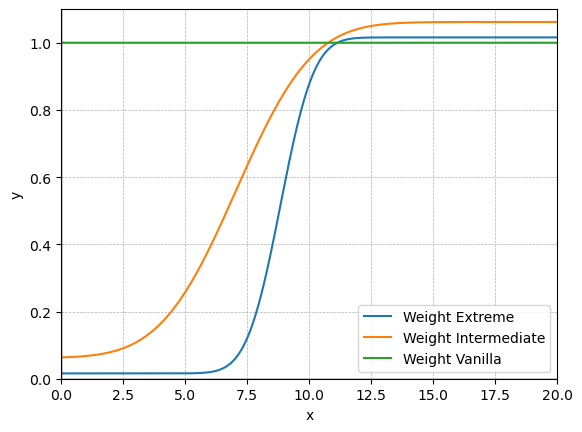

In [20]:
plt.plot(x, y_extreme, label='Weight Extreme')
plt.plot(x, y_intermediate, label='Weight Intermediate')
plt.plot(x, x_base, label='Weight Vanilla')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(0,20)
plt.ylim(0, 1.1)
plt.legend()
plt.show()

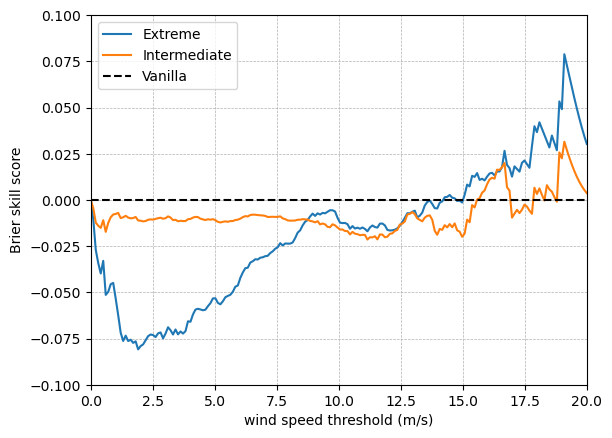

In [21]:
values = np.linspace(0,20, 200)
ylim = [-0.1, 0.1]
make_brier_skill_plot_tf(emos_base, linear_weight_models, test_data0, values, ylim=ylim, name_base_model='Vanilla')

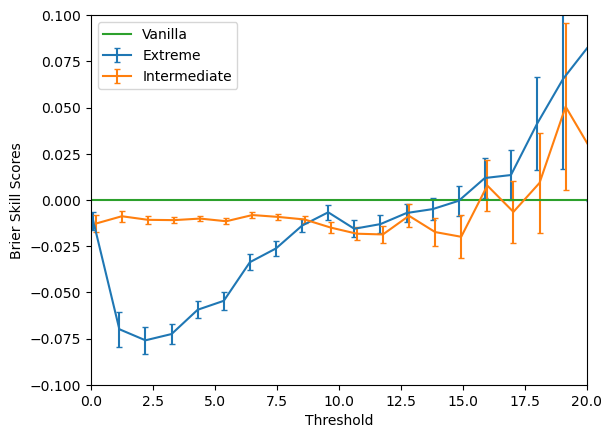

In [22]:
ylim = [-0.1,0.1]
values = np.linspace(0,20,20)
make_bootstrap_brier_efficient(emos_base, linear_weight_models, test_data0, values, ylim=ylim, bootstrap_size=1000, name_base_model='Vanilla')

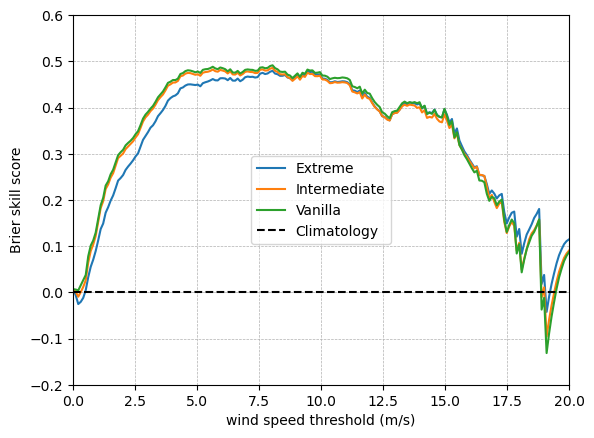

In [23]:
values = np.linspace(0.01,20, 200)
ylim = [-0.2, 0.6]
make_brier_skill_plot_tf(climatology, all_linear_models, test_data0, values, ylim=ylim, name_base_model='Climatology')

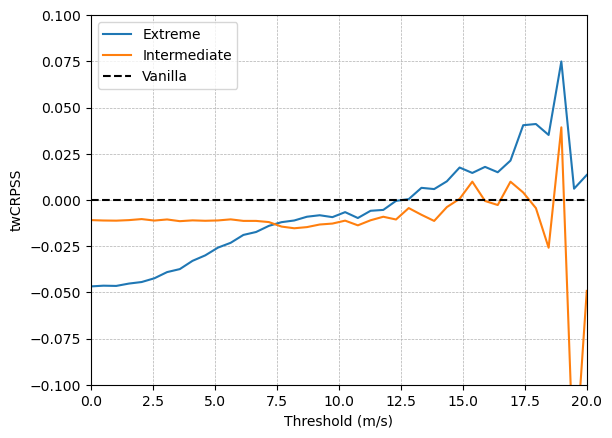

In [24]:
values = np.linspace(0,20,40)
make_twcrpss_plot_tf(emos_base, linear_weight_models, test_data0, values, ylim=[-0.1,0.1], sample_size=5000, base_model_name='Vanilla')

There are 637 values in the PIT diagram


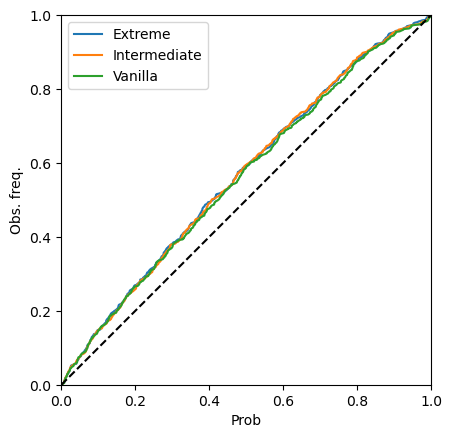

In [ ]:
threshold = 10
make_cpit_diagram_tf(linear_weight_models, test_data0_original, t=threshold, base_model=emos_base, base_model_name='Vanilla')

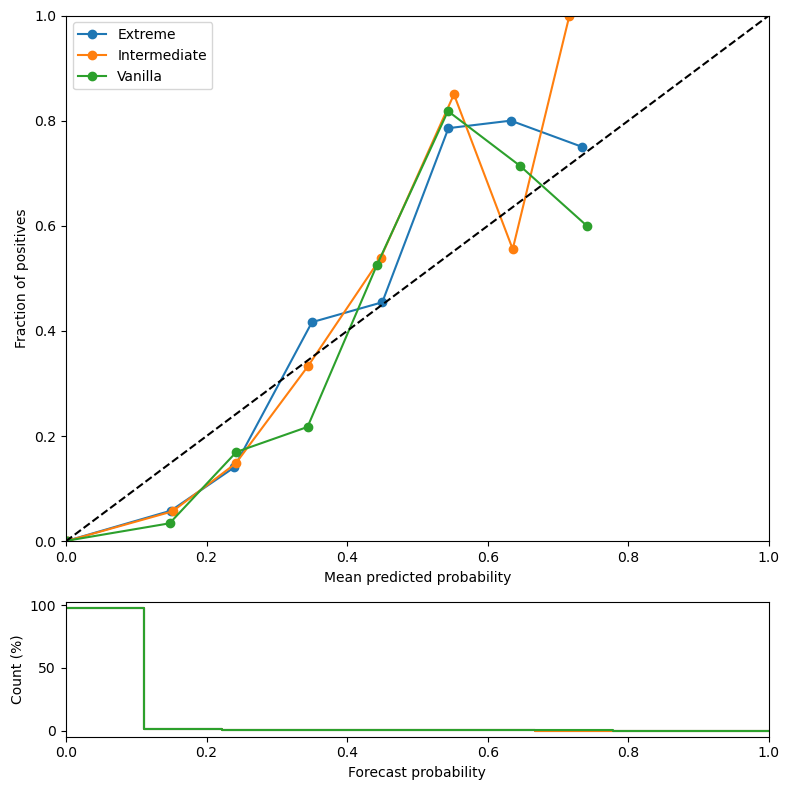

In [ ]:
threshold = 15
make_reliability_and_sharpness_tf(linear_weight_models, test_data0, t=threshold, base_model=emos_base, base_model_name='Vanilla')

## Result of Cross-Validation

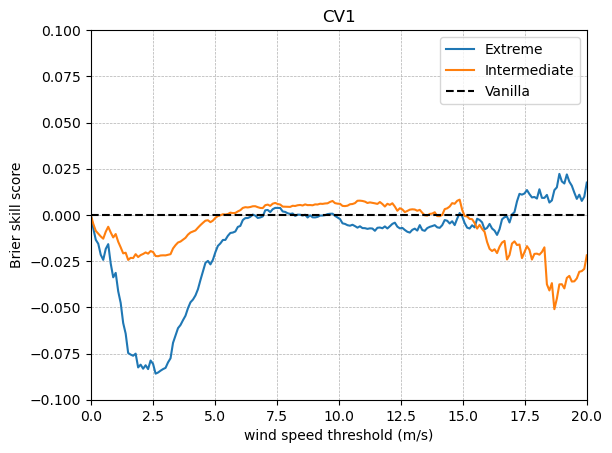

In [ ]:
values = np.linspace(0,20, 200)
ylim = [-0.1, 0.1]
make_brier_skill_plot_tf(emos_base1, linear_weight_models1, test_data1, values, ylim=ylim, name_base_model='Vanilla', title='CV1')

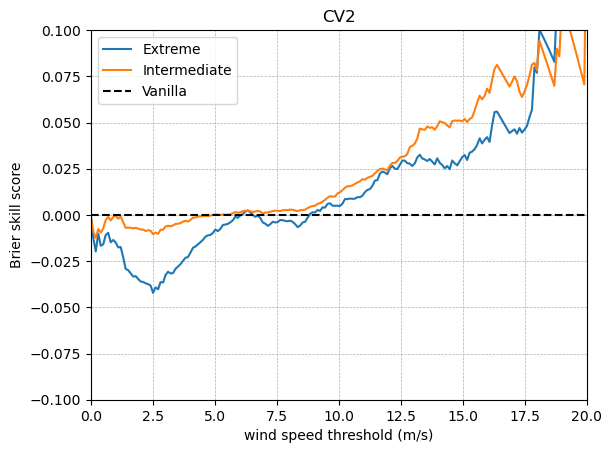

In [ ]:
values = np.linspace(0,20, 200)
ylim = [-0.1, 0.1]
make_brier_skill_plot_tf(emos_base2, linear_weight_models2, test_data2, values, ylim=ylim, name_base_model='Vanilla', title='CV2')

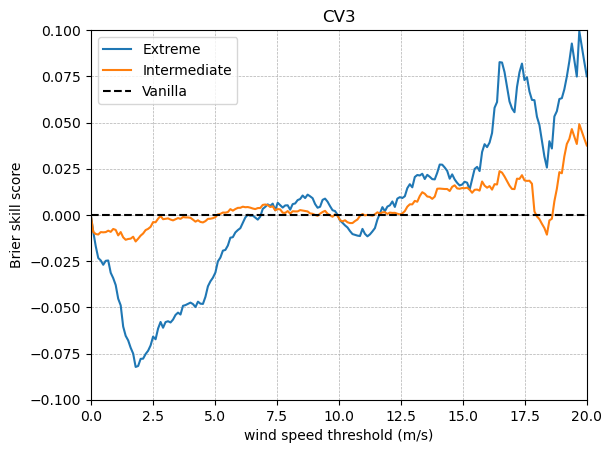

In [ ]:
values = np.linspace(0,20, 200)
ylim = [-0.1, 0.1]
make_brier_skill_plot_tf(emos_base3, linear_weight_models3, test_data3, values, ylim=ylim, name_base_model='Vanilla', title='CV3')

### Results CNNs